<a href="https://colab.research.google.com/github/marco-siino/bnn-neurips2026/blob/main/BNN_NeurIPS2026.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ==============================================================================
# BNN: Brain Neural Network for N-MNIST (NeurIPS 2025 Submission Prototype)
# ==============================================================================

!pip install tonic

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import tonic
from torch.utils.data import DataLoader

# Hyperparameters per il setup sperimentale NeurIPS
BATCH_SIZE = 64
NUM_SPIKES = 150 # Definizione della sparsità O(S)
EPOCHS = 5

transform = BNNEventTransform(num_spikes=NUM_SPIKES)

print("Inizializzazione Dataloader (Tonic scaricherà N-MNIST se necessario)...")
trainset = tonic.datasets.NMNIST(save_to='./data', train=True, transform=transform)
testset = tonic.datasets.NMNIST(save_to='./data', train=False, transform=transform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.2/106.2 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.9/131.9 kB 16.3 MB/s eta 0:00:00
  Created wheel for expelliarmus: filename=expelliarmus-1.1.12-cp312-cp312-linux_x86_64.whl size=56415 sha256=1123af952ecc360bdc58a6859176a0ae0826af1daa4798b06e2b554506972b3b
  Stored in directory: /root/.cache/pip/wheels/9a/9e/4b/f96da4dab397e63f90078766122e078e4ba82b2b48e07ee644
Successfully built expelliarmus
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
o

In [1]:
# ==========================================
# 1. TRASDUTTORE FISICO (Data Preprocessing)
# ==========================================
class BNNEventTransform:
    """
    Mappa gli eventi DVS grezzi nello stato iniziale dei pacchetti BNN.
    Garantisce una complessità di routing strettamente O(S) fissando num_spikes.
    """
    def __init__(self, num_spikes=150, sensor_size=(34, 34, 2)):
        self.num_spikes = num_spikes
        self.sensor_size = sensor_size

    def __call__(self, events):
        # Sottocampionamento o padding per avere esattamente 'num_spikes' (S)
        if len(events) >= self.num_spikes:
            idx = np.random.choice(len(events), self.num_spikes, replace=False)
            events = events[idx]
        else:
            pad_size = self.num_spikes - len(events)
            pad = np.zeros(pad_size, dtype=events.dtype)
            events = np.concatenate([events, pad])

        # Mappatura coordinate su varietà continua M: [-1, 1]
        x_norm = (events['x'] / (self.sensor_size[0] - 1)) * 2.0 - 1.0
        y_norm = (events['y'] / (self.sensor_size[1] - 1)) * 2.0 - 1.0

        # Mappatura polarità: {0, 1} -> {-1.0, 1.0}
        p = events['p'] * 2.0 - 1.0

        # Vettore di input u: (S, 3)
        bnn_input = np.stack([x_norm, y_norm, p], axis=-1)
        return torch.tensor(bnn_input, dtype=torch.float32)

# ==========================================
# 2. CORE DYNAMICS: CAMPO E ROUTING
# ==========================================
class BNNContinuousField(nn.Module):
    def __init__(self, spatial_dims=2, hidden_dim=64):
        super().__init__()
        # Rete neurale che approssima il campo scalare Phi(x)
        self.field = nn.Sequential(
            nn.Linear(spatial_dims, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.field(x)

    def compute_gradient(self, x):
        """
        Calcola analiticamente -Grad(Phi) rispetto alla posizione dei pacchetti.
        Questa è la forza conservativa che spinge i pacchetti verso i Sink.
        """
        with torch.enable_grad():
            x = x.requires_grad_(True)
            phi = self.forward(x)
            # Calcolo del gradiente spaziale mantenendo il grafo per BPTT
            grad_phi = torch.autograd.grad(
                outputs=phi,
                inputs=x,
                grad_outputs=torch.ones_like(phi),
                create_graph=True,
                retain_graph=True
            )[0]
        return -grad_phi

class BNNRouter(nn.Module):
    def __init__(self, input_features=3, spatial_dims=2, dt=0.1, gamma=0.5, steps=10):
        super().__init__()
        self.dt = dt
        self.gamma = gamma # Attrito viscoso
        self.steps = steps

        # Eq 6 e 7: Proiezioni dell'input u in Velocità Semantica e Massa
        self.W_v = nn.Linear(input_features, spatial_dims, bias=False)
        self.W_m = nn.Linear(input_features, 1)

        # Epsilon critico per la stabilità numerica dell'integratore
        self.min_mass = 1e-2

        self.phi_field = BNNContinuousField(spatial_dims)

    def forward(self, u_features, start_positions):
        # Inizializzazione Fisica
        v_p = self.W_v(u_features)
        m_p = torch.sigmoid(self.W_m(u_features)) + self.min_mass
        x_p = start_positions.clone()

        # Integrazione Semi-Implicita di Eulero
        for _ in range(self.steps):
            # Forza = spinta del gradiente - attrito viscoso
            force = self.phi_field.compute_gradient(x_p) - self.gamma * v_p

            # Aggiornamento Velocità (accumula accelerazione dipendente dalla massa)
            v_p = v_p + (force / m_p) * self.dt

            # Aggiornamento Posizione
            x_p = x_p + v_p * self.dt

        return x_p

# ==========================================
# 3. SINK NEURONS (Integrazione Spaziale)
# ==========================================
class SpatialSinkNeurons(nn.Module):
    def __init__(self, num_classes=10, spatial_dims=2, r_dendrite=1.0):
        super().__init__()
        self.num_classes = num_classes
        self.r_dendrite = r_dendrite

        # Posizioni apprendibili dei 10 neuroni bersaglio nella varietà M
        self.sink_positions = nn.Parameter(torch.randn(1, num_classes, spatial_dims))

    def forward(self, final_packet_positions, polarities):
        # Calcola le distanze euclidee a coppie: shape (batch, num_spikes, num_classes)
        dists = torch.norm(
            final_packet_positions.unsqueeze(2) - self.sink_positions.unsqueeze(0),
            dim=-1
        )

        # Campo recettivo "Soft" (ReLU) per permettere la backprop.
        # Più un pacchetto è vicino al centro del sink, maggiore è l'accumulo.
        arrivals = torch.relu(self.r_dendrite - dists)

        # Moduliamo l'accumulo con la polarità originale del segnale (carica)
        membrane_potentials = (arrivals * polarities.unsqueeze(2)).sum(dim=1)
        return membrane_potentials

# ==========================================
# 4. MODELLO COMPLETO E LOOP PRINCIPALE
# ==========================================
class NMNIST_BNN(nn.Module):
    def __init__(self, input_features=3, spatial_dims=2, num_classes=10):
        super().__init__()
        self.router = BNNRouter(input_features, spatial_dims)
        self.sinks = SpatialSinkNeurons(num_classes, spatial_dims)

    def forward(self, events):
        u_features = events
        start_positions = events[..., :2] # Le coordinate (x_norm, y_norm)
        polarities = events[..., 2]       # La carica p

        final_positions = self.router(u_features, start_positions)
        logits = self.sinks(final_positions, polarities)
        return logits

def main():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Esecuzione su dispositivo: {device}\n")

    model = NMNIST_BNN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=2e-3)
    criterion = nn.CrossEntropyLoss()

    print("\n--- INIZIO ADDESTRAMENTO BNN SU N-MNIST ---")
    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        for i, (events, labels) in enumerate(trainloader):
            events, labels = events.to(device), labels.to(device)

            optimizer.zero_grad()
            logits = model(events)
            loss = criterion(logits, labels)
            loss.backward()

            # CRITICO: Gradient clipping per prevenire collassi del campo potenziale
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += loss.item()
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            if (i + 1) % 100 == 0:
                print(f"Epoca [{epoch+1}/{EPOCHS}], Batch [{i+1}/{len(trainloader)}], "
                      f"Loss: {epoch_loss/100:.4f}, Acc: {100.*correct/total:.2f}%")
                epoch_loss = 0.0

    print("\n--- VALUTAZIONE FINALE ---")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for events, labels in testloader:
            events, labels = events.to(device), labels.to(device)
            logits = model(events)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Test Accuracy: {100.*correct/total:.2f}%")
    print(f"Efficienza: Processati solo {NUM_SPIKES} spike per cifra (Routing lineare).")

if __name__ == "__main__":
    main()

Esecuzione su dispositivo: cpu

Inizializzazione Dataloader (Tonic scaricherà N-MNIST se necessario)...


  0%|          | 0/1011893601 [00:00<?, ?it/s]

Extracting ./data/NMNIST/train.zip to ./data/NMNIST


  0%|          | 0/169674850 [00:00<?, ?it/s]

Extracting ./data/NMNIST/test.zip to ./data/NMNIST

--- INIZIO ADDESTRAMENTO BNN SU N-MNIST ---
Epoca [1/5], Batch [100/937], Loss: 2.5742, Acc: 11.25%
Epoca [1/5], Batch [200/937], Loss: 2.2913, Acc: 12.19%
Epoca [1/5], Batch [300/937], Loss: 2.2947, Acc: 12.18%
Epoca [1/5], Batch [400/937], Loss: 2.2838, Acc: 12.68%
Epoca [1/5], Batch [500/937], Loss: 2.2723, Acc: 12.83%
Epoca [1/5], Batch [600/937], Loss: 2.2508, Acc: 13.17%
Epoca [1/5], Batch [700/937], Loss: 2.2463, Acc: 13.53%
Epoca [1/5], Batch [800/937], Loss: 2.2296, Acc: 13.90%
Epoca [1/5], Batch [900/937], Loss: 2.2109, Acc: 14.33%
Epoca [2/5], Batch [100/937], Loss: 2.2077, Acc: 17.23%
Epoca [2/5], Batch [200/937], Loss: 2.2151, Acc: 17.27%
Epoca [2/5], Batch [300/937], Loss: 2.2085, Acc: 17.53%
Epoca [2/5], Batch [400/937], Loss: 2.2032, Acc: 17.64%
Epoca [2/5], Batch [500/937], Loss: 2.2041, Acc: 17.76%
Epoca [2/5], Batch [600/937], Loss: 2.2080, Acc: 17.81%
Epoca [2/5], Batch [700/937], Loss: 2.1897, Acc: 18.05%
Epoca [2

KeyboardInterrupt: 

# Codice completo con training veloce di Hebbian

In [3]:
# ==============================================================================
# BNN: Brain Neural Network for N-MNIST (NeurIPS 2025 Submission Prototype)
# Physics-Informed Routing with Constrained Hebbian Learning
# ==============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import tonic
from torch.utils.data import DataLoader

# ==========================================
# 1. PHYSICAL TRANSDUCER (Data Preprocessing)
# ==========================================
class BNNEventTransform:
    """
    Maps raw DVS events to the initial state of BNN packets.
    Enforces strictly O(S) routing complexity by fixing num_spikes.
    """
    def __init__(self, num_spikes=150, sensor_size=(34, 34, 2)):
        self.num_spikes = num_spikes
        self.sensor_size = sensor_size

    def __call__(self, events):
        # Subsample or pad to maintain constant S complexity
        if len(events) >= self.num_spikes:
            idx = np.random.choice(len(events), self.num_spikes, replace=False)
            events = events[idx]
        else:
            pad_size = self.num_spikes - len(events)
            pad = np.zeros(pad_size, dtype=events.dtype)
            events = np.concatenate([events, pad])

        # Map coordinates to continuous manifold M: [-1, 1]
        x_norm = (events['x'] / (self.sensor_size[0] - 1)) * 2.0 - 1.0
        y_norm = (events['y'] / (self.sensor_size[1] - 1)) * 2.0 - 1.0

        # Map polarity: {0, 1} -> {-1.0, 1.0}
        p = events['p'] * 2.0 - 1.0

        # Input vector u: (S, 3)
        bnn_input = np.stack([x_norm, y_norm, p], axis=-1)
        return torch.tensor(bnn_input, dtype=torch.float32)

# ==========================================
# 2. CORE DYNAMICS: CONTINUOUS FIELD & ROUTING
# ==========================================
class BNNContinuousField(nn.Module):
    def __init__(self, spatial_dims=2, hidden_dim=64):
        super().__init__()
        # Neural network approximating the scalar potential field Phi(x).
        # Tanh constrains the potential to [-1, 1] to prevent thermodynamic collapse.
        self.field = nn.Sequential(
            nn.Linear(spatial_dims, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.field(x)

    def compute_gradient(self, x):
        """
        Computes the spatial gradient via Central Finite Differences.
        Bypasses the expensive Hessian computation associated with BPTT.
        """
        eps = 1e-3
        dx = torch.tensor([eps, 0.0], dtype=torch.float32, device=x.device)
        dy = torch.tensor([0.0, eps], dtype=torch.float32, device=x.device)

        phi_plus_dx = self.forward(x + dx)
        phi_minus_dx = self.forward(x - dx)
        phi_plus_dy = self.forward(x + dy)
        phi_minus_dy = self.forward(x - dy)

        grad_x = (phi_plus_dx - phi_minus_dx) / (2 * eps)
        grad_y = (phi_plus_dy - phi_minus_dy) / (2 * eps)
        grad_phi = torch.cat([grad_x, grad_y], dim=-1)

        # Returns the conservative force (-Grad)
        return -grad_phi

class BNNRouter(nn.Module):
    def __init__(self, input_features=3, spatial_dims=2, dt=0.1, gamma=0.5, steps=10):
        super().__init__()
        self.dt = dt
        self.gamma = gamma # Viscous friction
        self.steps = steps

        # Semantic Velocity and Learned Inertial Mass
        self.W_v = nn.Linear(input_features, spatial_dims, bias=False)
        self.W_m = nn.Linear(input_features, 1)
        self.min_mass = 1e-2 # Critical stability bound

        self.phi_field = BNNContinuousField(spatial_dims)

    def forward(self, u_features, start_positions):
        v_p = self.W_v(u_features)
        m_p = torch.sigmoid(self.W_m(u_features)) + self.min_mass
        x_p = start_positions.clone()

        trajectories = []

        # Semi-Implicit Euler Integration
        for _ in range(self.steps):
            force = self.phi_field.compute_gradient(x_p) - self.gamma * v_p
            v_p = v_p + (force / m_p) * self.dt
            x_p = x_p + v_p * self.dt
            trajectories.append(x_p.clone())

        return x_p, torch.stack(trajectories, dim=2)

# ==========================================
# 3. SINK NEURONS (Spatial Integration)
# ==========================================
class SpatialSinkNeurons(nn.Module):
    def __init__(self, num_classes=10, spatial_dims=2, r_dendrite=1.0):
        super().__init__()
        self.num_classes = num_classes
        self.r_dendrite = r_dendrite
        # Learnable coordinates of the target functional clusters
        self.sink_positions = nn.Parameter(torch.randn(1, num_classes, spatial_dims))

    def forward(self, final_packet_positions, polarities):
        dists = torch.norm(
            final_packet_positions.unsqueeze(2) - self.sink_positions.unsqueeze(0),
            dim=-1
        )
        arrivals = torch.relu(self.r_dendrite - dists)
        membrane_potentials = (arrivals * polarities.unsqueeze(2)).sum(dim=1)
        return membrane_potentials

# ==========================================
# 4. FULL MODEL & MAIN LOOP
# ==========================================
class NMNIST_BNN(nn.Module):
    def __init__(self, input_features=3, spatial_dims=2, num_classes=10):
        super().__init__()
        self.router = BNNRouter(input_features, spatial_dims)
        self.sinks = SpatialSinkNeurons(num_classes, spatial_dims)

    def forward(self, events):
        u_features = events
        start_positions = events[..., :2]
        polarities = events[..., 2]

        final_positions, trajectories = self.router(u_features, start_positions)
        logits = self.sinks(final_positions, polarities)

        return logits, trajectories

# Hyperparameters per il setup sperimentale NeurIPS
BATCH_SIZE = 64
NUM_SPIKES = 150
EPOCHS = 10

transform = BNNEventTransform(num_spikes=NUM_SPIKES)
print("Initializing Dataloader...")
trainset = tonic.datasets.NMNIST(save_to='./data', train=True, transform=transform)
testset = tonic.datasets.NMNIST(save_to='./data', train=False, transform=transform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NMNIST_BNN().to(device)

def main():
    print(f"Executing on device: {device}\n")

    optimizer = optim.Adam(model.parameters(), lr=3e-3)
    criterion = nn.CrossEntropyLoss()

    print("\n--- BEGIN BNN TRAINING (Constrained Hebbian Learning) ---")
    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        for i, (events, labels) in enumerate(trainloader):
            events, labels = events.to(device), labels.to(device)
            optimizer.zero_grad()

            # 1. PHYSICAL FORWARD PASS
            logits, trajectories = model(events)

            # 2. GLOBAL ERROR SIGNAL COMPUTATION
            preds = logits.argmax(dim=1)
            delta = (preds == labels).float() * 2.0 - 1.0 # Map {0, 1} to {-1, 1}

            # 3. TOPOLOGICAL TERRAFORMING (Field-Modulated Hebbian Learning)
            flat_trajectories = trajectories.view(-1, 2)
            phi_values = model.router.phi_field(flat_trajectories).view(BATCH_SIZE, -1)

            # If delta=+1, we minimize +Phi (creates an attractor valley, Phi -> -1).
            # If delta=-1, we minimize -Phi (creates a repulsor hill, Phi -> +1).
            hebbian_loss = (delta.unsqueeze(1) * phi_values).mean()

            # Combined Loss (0.05 scaling prevents topological regularization from overpowering CrossEntropy)
            class_loss = criterion(logits, labels)
            total_loss = class_loss + 0.05 * hebbian_loss

            # 4. FAST SPATIAL BACKPROPAGATION
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += total_loss.item()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            if (i + 1) % 50 == 0:
                print(f"Epoch [{epoch+1}/{EPOCHS}], Batch [{i+1}/{len(trainloader)}], "
                      f"Loss: {epoch_loss/50:.4f}, Acc: {100.*correct/total:.2f}%")
                epoch_loss = 0.0

    print("\n--- FINAL EVALUATION ---")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for events, labels in testloader:
            events, labels = events.to(device), labels.to(device)
            logits, _ = model(events)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Test Accuracy: {100.*correct/total:.2f}%")
    print(f"Efficiency: Processed {NUM_SPIKES} spikes per digit (Linear Routing).")

if __name__ == "__main__":
    main()


Executing on device: cuda

Initializing Dataloader...

--- BEGIN BNN TRAINING (Constrained Hebbian Learning) ---
Epoch [1/10], Batch [50/937], Loss: 3.3077, Acc: 9.47%
Epoch [1/10], Batch [100/937], Loss: 2.3188, Acc: 10.16%
Epoch [1/10], Batch [150/937], Loss: 2.3075, Acc: 10.00%
Epoch [1/10], Batch [200/937], Loss: 2.3119, Acc: 10.05%
Epoch [1/10], Batch [250/937], Loss: 2.2974, Acc: 10.07%
Epoch [1/10], Batch [300/937], Loss: 2.2930, Acc: 10.09%
Epoch [1/10], Batch [350/937], Loss: 2.2901, Acc: 10.12%
Epoch [1/10], Batch [400/937], Loss: 2.2837, Acc: 10.18%
Epoch [1/10], Batch [450/937], Loss: 2.2853, Acc: 10.12%
Epoch [1/10], Batch [500/937], Loss: 2.2751, Acc: 10.26%
Epoch [1/10], Batch [550/937], Loss: 2.2728, Acc: 10.51%
Epoch [1/10], Batch [600/937], Loss: 2.2380, Acc: 10.96%
Epoch [1/10], Batch [650/937], Loss: 2.1889, Acc: 11.51%
Epoch [1/10], Batch [700/937], Loss: 2.1736, Acc: 12.02%
Epoch [1/10], Batch [750/937], Loss: 2.1519, Acc: 12.51%
Epoch [1/10], Batch [800/937], Los

In [7]:
# ==============================================================================
# BNN: Brain Neural Network for N-MNIST (NeurIPS 2025 Submission Prototype)
# Physics-Informed Routing with Constrained Hebbian Learning
# ==============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import tonic
from torch.utils.data import DataLoader

# ==========================================
# 1. PHYSICAL TRANSDUCER (Data Preprocessing)
# ==========================================
class BNNEventTransform:
    """
    Maps raw DVS events to the initial state of BNN packets.
    Enforces strictly O(S) routing complexity by fixing num_spikes.
    """
    def __init__(self, num_spikes=150, sensor_size=(34, 34, 2)):
        self.num_spikes = num_spikes
        self.sensor_size = sensor_size

    def __call__(self, events):
        # Subsample or pad to maintain constant S complexity
        if len(events) >= self.num_spikes:
            idx = np.random.choice(len(events), self.num_spikes, replace=False)
            events = events[idx]
        else:
            pad_size = self.num_spikes - len(events)
            pad = np.zeros(pad_size, dtype=events.dtype)
            events = np.concatenate([events, pad])

        # Map coordinates to continuous manifold M: [-1, 1]
        x_norm = (events['x'] / (self.sensor_size[0] - 1)) * 2.0 - 1.0
        y_norm = (events['y'] / (self.sensor_size[1] - 1)) * 2.0 - 1.0

        # Map polarity: {0, 1} -> {-1.0, 1.0}
        p = events['p'] * 2.0 - 1.0

        # Input vector u: (S, 3)
        bnn_input = np.stack([x_norm, y_norm, p], axis=-1)
        return torch.tensor(bnn_input, dtype=torch.float32)

# ==========================================
# 2. CORE DYNAMICS: CONTINUOUS FIELD & ROUTING
# ==========================================
class BNNContinuousField(nn.Module):
    def __init__(self, spatial_dims=2, hidden_dim=64):
        super().__init__()
        # Neural network approximating the scalar potential field Phi(x).
        # Tanh constrains the potential to [-1, 1] to prevent thermodynamic collapse.
        self.field = nn.Sequential(
            nn.Linear(spatial_dims, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.field(x)

    def compute_gradient(self, x):
        """
        Computes the spatial gradient via Central Finite Differences.
        Bypasses the expensive Hessian computation associated with BPTT.
        """
        eps = 1e-3
        dx = torch.tensor([eps, 0.0], dtype=torch.float32, device=x.device)
        dy = torch.tensor([0.0, eps], dtype=torch.float32, device=x.device)

        phi_plus_dx = self.forward(x + dx)
        phi_minus_dx = self.forward(x - dx)
        phi_plus_dy = self.forward(x + dy)
        phi_minus_dy = self.forward(x - dy)

        grad_x = (phi_plus_dx - phi_minus_dx) / (2 * eps)
        grad_y = (phi_plus_dy - phi_minus_dy) / (2 * eps)
        grad_phi = torch.cat([grad_x, grad_y], dim=-1)

        # Returns the conservative force (-Grad)
        return -grad_phi

class BNNRouter(nn.Module):
    def __init__(self, input_features=3, spatial_dims=2, dt=0.1, gamma=0.5, steps=10):
        super().__init__()
        self.dt = dt
        self.gamma = gamma # Viscous friction
        self.steps = steps

        # Semantic Velocity and Learned Inertial Mass
        self.W_v = nn.Linear(input_features, spatial_dims, bias=False)
        self.W_m = nn.Linear(input_features, 1)
        self.min_mass = 1e-2 # Critical stability bound

        self.phi_field = BNNContinuousField(spatial_dims)

    def forward(self, u_features, start_positions):
        v_p = self.W_v(u_features)
        m_p = torch.sigmoid(self.W_m(u_features)) + self.min_mass
        x_p = start_positions.clone()

        trajectories = []

        # Semi-Implicit Euler Integration
        for _ in range(self.steps):
            force = self.phi_field.compute_gradient(x_p) - self.gamma * v_p
            v_p = v_p + (force / m_p) * self.dt
            x_p = x_p + v_p * self.dt
            trajectories.append(x_p.clone())

        return x_p, torch.stack(trajectories, dim=2)

# ==========================================
# 3. SINK NEURONS (Spatial Integration)
# ==========================================
class SpatialSinkNeurons(nn.Module):
    def __init__(self, num_classes=10, spatial_dims=2, r_dendrite=1.0):
        super().__init__()
        self.num_classes = num_classes
        self.r_dendrite = r_dendrite
        # Learnable coordinates of the target functional clusters
        self.sink_positions = nn.Parameter(torch.randn(1, num_classes, spatial_dims))

    def forward(self, final_packet_positions, polarities):
        dists = torch.norm(
            final_packet_positions.unsqueeze(2) - self.sink_positions.unsqueeze(0),
            dim=-1
        )
        arrivals = torch.relu(self.r_dendrite - dists)
        membrane_potentials = (arrivals * polarities.unsqueeze(2)).sum(dim=1)
        return membrane_potentials

# ==========================================
# 4. FULL MODEL & MAIN LOOP
# ==========================================
class NMNIST_BNN(nn.Module):
    def __init__(self, input_features=3, spatial_dims=2, num_classes=10):
        super().__init__()
        self.router = BNNRouter(input_features, spatial_dims)
        self.sinks = SpatialSinkNeurons(num_classes, spatial_dims)

    def forward(self, events):
        u_features = events
        start_positions = events[..., :2]
        polarities = events[..., 2]

        final_positions, trajectories = self.router(u_features, start_positions)
        logits = self.sinks(final_positions, polarities)

        return logits, trajectories

# Hyperparameters per il setup sperimentale NeurIPS
BATCH_SIZE = 64
NUM_SPIKES = 150
EPOCHS = 10

transform = BNNEventTransform(num_spikes=NUM_SPIKES)
print("Initializing Dataloader...")
trainset = tonic.datasets.NMNIST(save_to='./data', train=True, transform=transform)
testset = tonic.datasets.NMNIST(save_to='./data', train=False, transform=transform)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NMNIST_BNN().to(device)

def main():
    print(f"Executing on device: {device}\n")

    optimizer = optim.Adam(model.parameters(), lr=3e-3)
    criterion = nn.CrossEntropyLoss()

    print("\n--- BEGIN BNN TRAINING (Constrained Hebbian Learning) ---")
    for epoch in range(EPOCHS):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        for i, (events, labels) in enumerate(trainloader):
            events, labels = events.to(device), labels.to(device)
            optimizer.zero_grad()

            # 1. PHYSICAL FORWARD PASS
            logits, trajectories = model(events)

            # 2. GLOBAL ERROR SIGNAL COMPUTATION
            preds = logits.argmax(dim=1)
            delta = (preds == labels).float() * 2.0 - 1.0 # Map {0, 1} to {-1, 1}

            # 3. TOPOLOGICAL TERRAFORMING (Field-Modulated Hebbian Learning)
            flat_trajectories = trajectories.view(-1, 2)
            phi_values = model.router.phi_field(flat_trajectories).view(BATCH_SIZE, -1)

            # If delta=+1, we minimize +Phi (creates an attractor valley, Phi -> -1).
            # If delta=-1, we minimize -Phi (creates a repulsor hill, Phi -> +1).
            hebbian_loss = (delta.unsqueeze(1) * phi_values).mean()

            # Combined Loss (0.05 scaling prevents topological regularization from overpowering CrossEntropy)
            class_loss = criterion(logits, labels)
            total_loss = class_loss + 0.05 * hebbian_loss

            # 4. FAST SPATIAL BACKPROPAGATION
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            epoch_loss += total_loss.item()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            if (i + 1) % 50 == 0:
                print(f"Epoch [{epoch+1}/{EPOCHS}], Batch [{i+1}/{len(trainloader)}], "
                      f"Loss: {epoch_loss/50:.4f}, Acc: {100.*correct/total:.2f}%")
                epoch_loss = 0.0

    print("\n--- FINAL EVALUATION ---")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for events, labels in testloader:
            events, labels = events.to(device), labels.to(device)
            logits, _ = model(events)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Test Accuracy: {100.*correct/total:.2f}%")
    print(f"Efficiency: Processed {NUM_SPIKES} spikes per digit (Linear Routing).")

if __name__ == "__main__":
    main()


Initializing Dataloader...
Executing on device: cuda


--- BEGIN BNN TRAINING (Constrained Hebbian Learning) ---
Epoch [1/10], Batch [50/937], Loss: 4.5333, Acc: 7.94%
Epoch [1/10], Batch [100/937], Loss: 2.6647, Acc: 8.86%
Epoch [1/10], Batch [150/937], Loss: 2.3157, Acc: 9.85%
Epoch [1/10], Batch [200/937], Loss: 2.2934, Acc: 10.80%
Epoch [1/10], Batch [250/937], Loss: 2.2819, Acc: 11.42%
Epoch [1/10], Batch [300/937], Loss: 2.2686, Acc: 11.89%
Epoch [1/10], Batch [350/937], Loss: 2.2580, Acc: 12.21%
Epoch [1/10], Batch [400/937], Loss: 2.2599, Acc: 12.59%
Epoch [1/10], Batch [450/937], Loss: 2.2503, Acc: 12.86%
Epoch [1/10], Batch [500/937], Loss: 2.2420, Acc: 13.15%
Epoch [1/10], Batch [550/937], Loss: 2.2400, Acc: 13.42%
Epoch [1/10], Batch [600/937], Loss: 2.2288, Acc: 13.71%
Epoch [1/10], Batch [650/937], Loss: 2.2246, Acc: 13.90%
Epoch [1/10], Batch [700/937], Loss: 2.2196, Acc: 14.10%
Epoch [1/10], Batch [750/937], Loss: 2.2137, Acc: 14.27%
Epoch [1/10], Batch [800/937], Loss:

# Visualizzazione Ante-Training

Generazione della mappa topologica e simulazione del routing in corso...


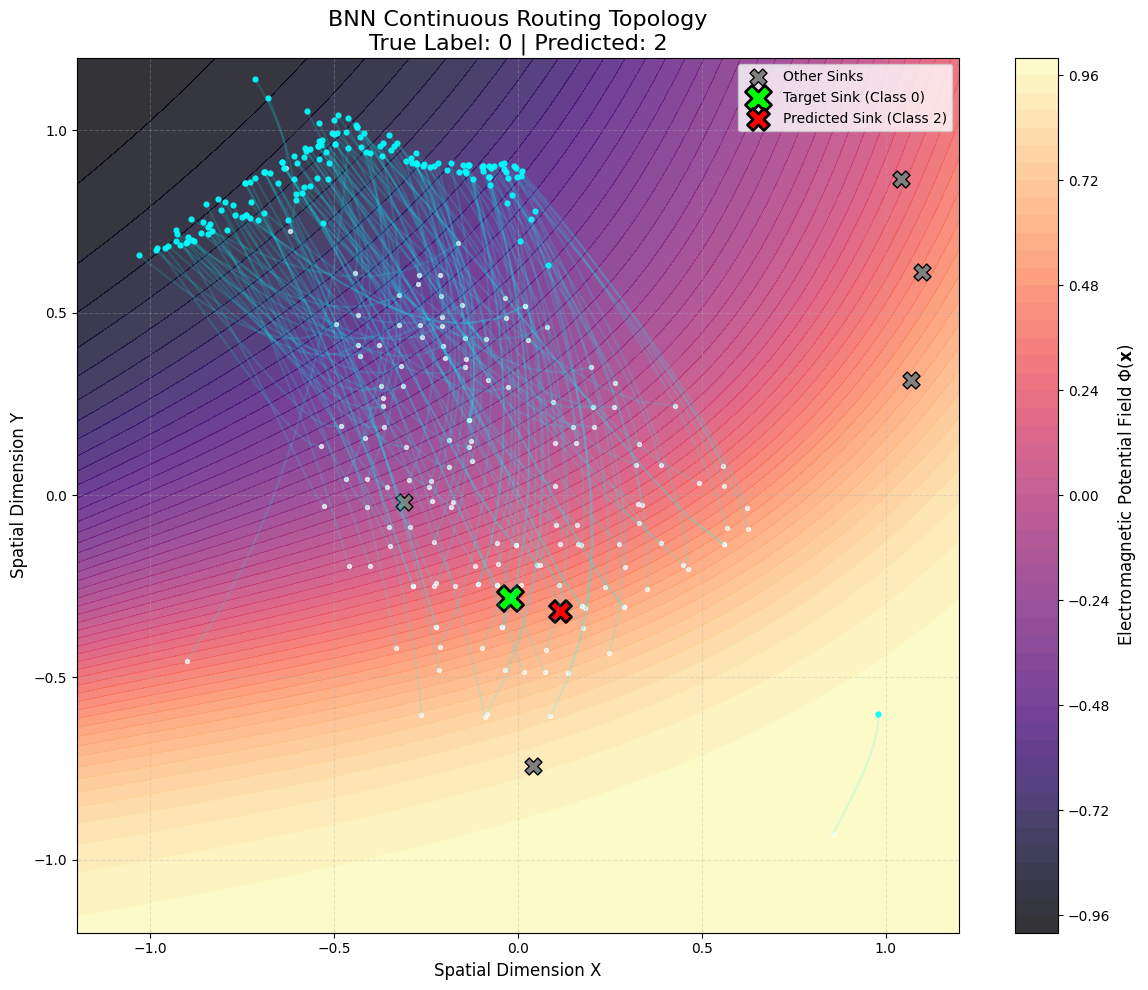

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_bnn_routing(model, testloader, device):
    print("Generazione della mappa topologica e simulazione del routing in corso...")
    model.eval()

    # 1. CAMPIONAMENTO DEL CAMPO POTENZIALE (La "Topografia")
    res = 100
    x_coords = np.linspace(-1.2, 1.2, res)
    y_coords = np.linspace(-1.2, 1.2, res)
    X, Y = np.meshgrid(x_coords, y_coords)

    grid_points = torch.tensor(
        np.stack([X.flatten(), Y.flatten()], axis=-1),
        dtype=torch.float32
    ).to(device)

    with torch.no_grad():
        Z = model.router.phi_field(grid_points).view(res, res).cpu().numpy()

    # 2. ESTRAZIONE DI UN SAMPLE REALE
    events, labels = next(iter(testloader))
    events = events.to(device)

    with torch.no_grad():
        logits, trajectories = model(events)

    sample_idx = 0
    sample_trajectories = trajectories[sample_idx].cpu().numpy()
    true_label = labels[sample_idx].item()
    pred_label = logits[sample_idx].argmax().item()

    sinks = model.sinks.sink_positions[0].detach().cpu().numpy()

    # 3. RENDERING GRAFICO
    fig, ax = plt.subplots(figsize=(12, 10))

    contour = ax.contourf(X, Y, Z, levels=50, cmap='magma', alpha=0.8)
    cbar = plt.colorbar(contour, ax=ax)

    # FIX: Aggiunta la 'r' (raw string) per supportare il LaTeX \Phi ed evitate il SyntaxWarning
    cbar.set_label(r'Electromagnetic Potential Field $\Phi(\mathbf{x})$', fontsize=12)

    num_spikes = sample_trajectories.shape[0]
    for s in range(num_spikes):
        ax.plot(sample_trajectories[s, :, 0], sample_trajectories[s, :, 1],
                color='cyan', alpha=0.15, linewidth=1.5)
        ax.scatter(sample_trajectories[s, 0, 0], sample_trajectories[s, 0, 1],
                   color='white', s=8, alpha=0.7)
        ax.scatter(sample_trajectories[s, -1, 0], sample_trajectories[s, -1, 1],
                   color='cyan', s=12, alpha=0.9)

    ax.scatter(sinks[:, 0], sinks[:, 1], marker='X', s=150, color='gray',
               edgecolor='black', label='Other Sinks')

    ax.scatter(sinks[true_label, 0], sinks[true_label, 1], marker='X', s=350,
               color='lime', edgecolor='black', linewidth=2,
               label=f'Target Sink (Class {true_label})')

    if true_label != pred_label:
        ax.scatter(sinks[pred_label, 0], sinks[pred_label, 1], marker='X', s=250,
                   color='red', edgecolor='black', linewidth=2,
                   label=f'Predicted Sink (Class {pred_label})')

    ax.set_title(f"BNN Continuous Routing Topology\nTrue Label: {true_label} | Predicted: {pred_label}", fontsize=16)
    ax.set_xlabel("Spatial Dimension X", fontsize=12)
    ax.set_ylabel("Spatial Dimension Y", fontsize=12)
    ax.legend(loc='upper right', fontsize=10)

    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Esegui la visualizzazione
visualize_bnn_routing(model, testloader, device)

# Visualizzazione Post-Training

Generazione della mappa topologica e simulazione del routing in corso...


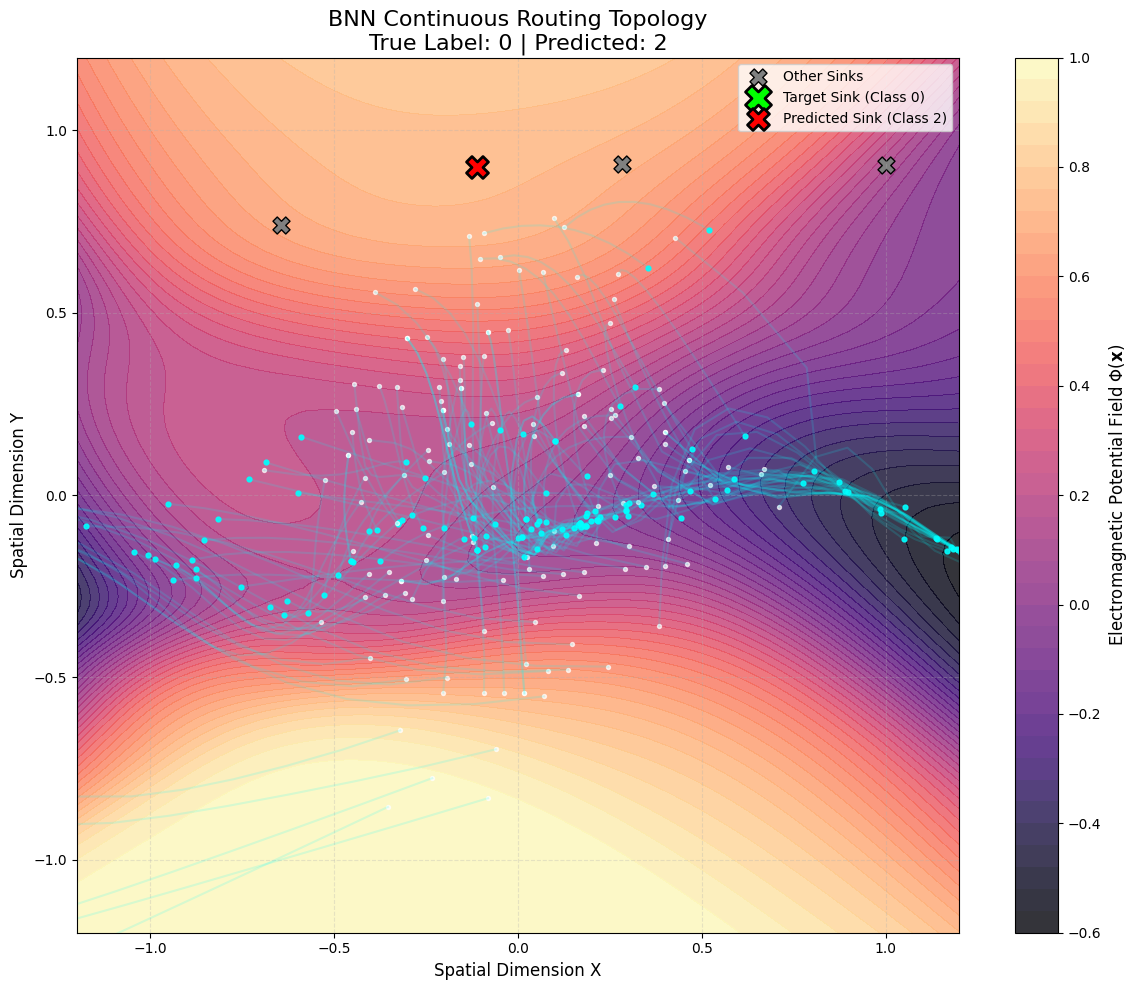

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_bnn_routing(model, testloader, device):
    print("Generazione della mappa topologica e simulazione del routing in corso...")
    model.eval()

    # 1. CAMPIONAMENTO DEL CAMPO POTENZIALE (La "Topografia")
    res = 100
    x_coords = np.linspace(-1.2, 1.2, res)
    y_coords = np.linspace(-1.2, 1.2, res)
    X, Y = np.meshgrid(x_coords, y_coords)

    grid_points = torch.tensor(
        np.stack([X.flatten(), Y.flatten()], axis=-1),
        dtype=torch.float32
    ).to(device)

    with torch.no_grad():
        Z = model.router.phi_field(grid_points).view(res, res).cpu().numpy()

    # 2. ESTRAZIONE DI UN SAMPLE REALE
    events, labels = next(iter(testloader))
    events = events.to(device)

    with torch.no_grad():
        logits, trajectories = model(events)

    sample_idx = 0
    sample_trajectories = trajectories[sample_idx].cpu().numpy()
    true_label = labels[sample_idx].item()
    pred_label = logits[sample_idx].argmax().item()

    sinks = model.sinks.sink_positions[0].detach().cpu().numpy()

    # 3. RENDERING GRAFICO
    fig, ax = plt.subplots(figsize=(12, 10))

    contour = ax.contourf(X, Y, Z, levels=50, cmap='magma', alpha=0.8)
    cbar = plt.colorbar(contour, ax=ax)

    # FIX: Aggiunta la 'r' (raw string) per supportare il LaTeX \Phi ed evitate il SyntaxWarning
    cbar.set_label(r'Electromagnetic Potential Field $\Phi(\mathbf{x})$', fontsize=12)

    num_spikes = sample_trajectories.shape[0]
    for s in range(num_spikes):
        ax.plot(sample_trajectories[s, :, 0], sample_trajectories[s, :, 1],
                color='cyan', alpha=0.15, linewidth=1.5)
        ax.scatter(sample_trajectories[s, 0, 0], sample_trajectories[s, 0, 1],
                   color='white', s=8, alpha=0.7)
        ax.scatter(sample_trajectories[s, -1, 0], sample_trajectories[s, -1, 1],
                   color='cyan', s=12, alpha=0.9)

    ax.scatter(sinks[:, 0], sinks[:, 1], marker='X', s=150, color='gray',
               edgecolor='black', label='Other Sinks')

    ax.scatter(sinks[true_label, 0], sinks[true_label, 1], marker='X', s=350,
               color='lime', edgecolor='black', linewidth=2,
               label=f'Target Sink (Class {true_label})')

    if true_label != pred_label:
        ax.scatter(sinks[pred_label, 0], sinks[pred_label, 1], marker='X', s=250,
                   color='red', edgecolor='black', linewidth=2,
                   label=f'Predicted Sink (Class {pred_label})')

    ax.set_title(f"BNN Continuous Routing Topology\nTrue Label: {true_label} | Predicted: {pred_label}", fontsize=16)
    ax.set_xlabel("Spatial Dimension X", fontsize=12)
    ax.set_ylabel("Spatial Dimension Y", fontsize=12)
    ax.legend(loc='upper right', fontsize=10)

    plt.xlim([-1.2, 1.2])
    plt.ylim([-1.2, 1.2])
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Esegui la visualizzazione
visualize_bnn_routing(model, testloader, device)